In [1]:
# import libraries
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import sklearn.model_selection
from sklearn.utils import shuffle
#from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Embedding
import math
from tensorflow.keras.models import load_model
from tensorflow.keras.models import model_from_json
import re
from transformers import TokenAndPositionEmbedding, TransformerBlock
import time

In [2]:
# import detected and undetected datasets
detected_peptides = pd.read_table('../data/detected_peptides_all_aaindex1.tsv')
undetected_peptides = pd.read_table('../data/undetected_peptides_all_aaindex1.tsv')

In [3]:
# keep detected and undetected peptides less than or equal to 40 aa AND greater than or equal to 7 aa in length
detected_peptides = detected_peptides.loc[(detected_peptides["Peptide"].str.len()>=7) & 
                                          (detected_peptides["Peptide"].str.len()<=40)].reset_index(drop=True)

undetected_peptides = undetected_peptides.loc[(undetected_peptides["Peptide"].str.len()>=7) & 
                                              (undetected_peptides["Peptide"].str.len()<=40)].reset_index(drop=True)

print(detected_peptides.shape)
print(undetected_peptides.shape)

(37837, 571)
(134282, 571)


In [4]:
# double check 0 peptides in undetected peptides are present in detected peptides
len(undetected_peptides[undetected_peptides["Peptide"].isin(detected_peptides["Peptide"])])

0

In [5]:
# drop unnecessary columns
detected_peptides = detected_peptides.drop(['Protein', 'PEP', 'Protein_length'], axis=1)
undetected_peptides = undetected_peptides.drop(['Protein', 'PEP', 'Protein_length'], axis=1)

print(detected_peptides.shape)
print(undetected_peptides.shape)

(37837, 568)
(134282, 568)


In [6]:
# add detectability column
detected_peptides.insert(loc=1, column='Detectability', value=1)
undetected_peptides.insert(loc=1, column='Detectability', value=0)

print(detected_peptides.shape)
print(undetected_peptides.shape)

(37837, 569)
(134282, 569)


In [7]:
detected_peptides.head()

,Peptide,Detectability,Quantification,ANDN920101,ARGP820101,ARGP820102,ARGP820103,BEGF750101,BEGF750102,BEGF750103,...,KARS160113,KARS160114,KARS160115,KARS160116,KARS160117,KARS160118,KARS160119,KARS160120,KARS160121,KARS160122
0,DFSALESQLQDTQELLQEENR,1,0.204082,92.33,12.36,22.69,21.80,13.17,14.65,13.88,...,241.0,380.122,270.0,454.0,713.007,133.94,537.463,-4.227,208.869,60.300
1,NADMSEEMQQDSVECATQALEK,1,0.146067,97.11,12.27,20.85,21.58,14.09,15.42,14.26,...,228.0,375.531,265.0,459.0,684.014,147.94,545.660,-4.406,216.602,61.570
2,ASASGSGAQVGGPISSGSSASSVTVTR,1,0.195783,115.44,12.07,23.95,25.26,13.99,18.85,19.32,...,168.0,297.981,194.0,390.0,545.021,159.77,482.653,-10.095,207.270,105.422
3,LSEEEILENPDLFLTSEATDYGR,1,0.069401,100.45,19.00,23.85,24.63,14.16,16.16,15.75,...,254.0,387.734,277.0,472.0,741.007,141.73,562.782,-11.055,223.858,77.698
4,IMQSSSEVGYDAMAGDFVNMVEK,1,0.335079,100.34,18.20,22.63,25.14,14.71,17.38,15.33,...,236.0,375.687,259.0,469.0,687.028,147.42,537.126,-2.780,219.424,66.769


In [8]:
# remove nan values
all_peptides = pd.concat([detected_peptides, undetected_peptides])
print(all_peptides.shape)
all_peptides = all_peptides.dropna(axis=1, how='any')
print(all_peptides.shape)
detected_peptides = all_peptides[all_peptides['Detectability'] == 1]
undetected_peptides = all_peptides[all_peptides['Detectability'] == 0]
print(detected_peptides.shape)
print(undetected_peptides.shape)

(172119, 569)
(172119, 556)
(37837, 556)
(134282, 556)


In [9]:
# take random sample of undetected_peptides, with equal number of rows to detected_peptides
# random_state is used for reproducibility
undetected_peptides_balanced = undetected_peptides.sample(n=detected_peptides.shape[0], 
                                                         random_state=42).reset_index(drop=True)
print(detected_peptides.shape)
print(undetected_peptides_balanced.shape)

(37837, 556)
(37837, 556)


In [10]:
undetected_peptides_balanced

,Peptide,Detectability,Quantification,ANDN920101,ARGP820101,ARGP820102,ARGP820103,BEGF750101,BEGF750102,BEGF750103,...,KARS160113,KARS160114,KARS160115,KARS160116,KARS160117,KARS160118,KARS160119,KARS160120,KARS160121,KARS160122
0,IWRPPMYQR,0,0.001679,39.78,13.03,7.92,9.32,4.50,6.82,7.08,...,146.0,206.135,147.0,250.0,371.000,54.387,236.732,-2.390,104.006,43.921
1,NGTHLDAGALTTTFEELHFEIKPHDDCTVEQIYEILK,0,0.043841,161.34,32.57,35.55,37.03,22.43,27.78,24.66,...,395.0,613.817,449.0,741.0,1200.014,220.840,893.243,-32.578,356.324,112.647
2,MAEESER,0,0.005042,30.62,3.85,5.35,6.47,5.06,4.67,4.28,...,85.0,140.974,94.0,176.0,239.000,46.340,172.880,0.000,70.935,18.322
3,AVGGAMR,0,0.024155,29.49,4.46,7.29,8.91,5.04,5.52,4.53,...,57.0,88.144,58.0,108.0,147.007,38.000,116.687,0.000,52.267,12.856
4,NIVHNYSEAEIK,0,0.003472,52.37,11.12,7.57,8.97,7.43,8.67,7.66,...,135.0,211.410,156.0,266.0,404.021,74.960,293.794,-6.155,116.990,32.966
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37832,CGTVGSR,0,0.003530,29.77,3.23,5.96,5.78,2.89,5.03,5.58,...,45.0,91.344,56.0,118.0,160.007,40.060,133.162,-4.227,55.667,28.200
37833,ALVIAPLFGIAQVVYFLGIAESLLGLLQDPQA,0,0.006192,136.01,35.39,46.69,47.57,22.30,25.29,18.79,...,315.0,440.511,330.0,512.0,866.021,189.020,693.766,-5.883,284.956,95.899
37834,YQEDFNPLVR,0,0.016867,44.37,10.29,8.73,9.14,5.40,7.36,7.19,...,133.0,195.641,143.0,232.0,373.014,61.790,264.513,-0.960,107.056,38.578
37835,EESELQR,0,0.000984,30.29,3.59,5.45,5.39,4.50,4.47,4.44,...,85.0,144.541,97.0,178.0,256.000,44.840,182.388,0.000,71.435,20.628


In [11]:
unused_undetected = undetected_peptides[~undetected_peptides["Peptide"].isin
                                        (undetected_peptides_balanced["Peptide"])]
unused_undetected.shape

(96445, 556)

# Create training, validation and test sets

## Split into train and test sets

In [12]:
# detected peptides
X_trainP, X_testP, y_trainP, y_testP = sklearn.model_selection.train_test_split(
    detected_peptides, detected_peptides['Detectability'], test_size=0.3, random_state=1)

In [13]:
# undetected peptides
X_trainN, X_testN, y_trainN, y_testN = sklearn.model_selection.train_test_split(
    undetected_peptides_balanced, undetected_peptides_balanced['Detectability'], test_size=0.3, random_state=1)

In [14]:
print(X_trainP.shape)
print(X_testP.shape)
print('')
print(X_trainN.shape)
print(X_testN.shape)

(26485, 556)
(11352, 556)

(26485, 556)
(11352, 556)


## split training into train and validation sets

In [15]:
# detected peptides
X_trainP, X_valP, y_trainP, y_valP = sklearn.model_selection.train_test_split(
    X_trainP, y_trainP, test_size=0.25, random_state=1)

In [16]:
# undetected peptides
X_trainN, X_valN, y_trainN, y_valN = sklearn.model_selection.train_test_split(
    X_trainN, y_trainN, test_size=0.25, random_state=1)

In [17]:
print(X_trainP.shape)
print(X_valP.shape)
print('')
print(X_trainN.shape)
print(X_valN.shape)

(19863, 556)
(6622, 556)

(19863, 556)
(6622, 556)


## create final training and validation sets

In [18]:
# create final training and validation sets
X_train = pd.concat([X_trainP, X_trainN])
X_val = pd.concat([X_valP] + [X_valN])
y_train = pd.concat([pd.Series(y_trainP)] + [pd.Series(y_trainN)])
y_val = pd.concat([pd.Series(y_valP)] + [pd.Series(y_valN)])

In [19]:
print(X_train.shape)
print(X_val.shape)
print('')
print(y_train.shape)
print(y_val.shape)

(39726, 556)
(13244, 556)

(39726,)
(13244,)


In [20]:
# check validation set is not in train
print(len(X_val[X_val["Peptide"].isin(X_train["Peptide"])]))

0


## create final test set

In [21]:
# create final test set
X_test = pd.concat([X_testP, X_testN])
y_test = pd.concat([pd.Series(y_testP)] + [pd.Series(y_testN)])
print(X_test.shape)
print(y_test.shape)

(22704, 556)
(22704,)


In [22]:
# check test is not in train or validation
print(len(X_test[X_test["Peptide"].isin(X_val["Peptide"])]))
print(len(X_test[X_test["Peptide"].isin(X_train["Peptide"])]))

0
0


## Pre-processing of train, validation and test sets

In [23]:
# integer-encode peptides
maxLength = 40

aaDict = {"-": 0, "A": 1, "R": 2, "N": 3, "D": 4, "C": 5, "Q": 6, "E": 7, "G": 8, "H": 9, "I": 10, "L": 11, 
          "K": 12, "M": 13, "F": 14, "P": 15, "S": 16, "T": 17, "W": 18, "Y": 19, "V": 20, "U": 21}

def convertPeptide(peptide, maxLength):
    j = 0
    hotPeptide = []
    for aa in peptide:
        hotPeptide.append(aaDict[aa])
        j = j + 1
    for k in range(maxLength - j):
        hotPeptide.append(0)

    return np.array(hotPeptide)

### Separate out each feature

In [24]:
# training set
X_train = shuffle(X_train, random_state=1).reset_index(drop=True)
y_train = shuffle(y_train, random_state=1).reset_index(drop=True)

X_train_peptide = X_train['Peptide'].apply(convertPeptide, args=(maxLength,))
X_train_nsaf = X_train['Quantification']
X_train_aaindex1 = X_train.iloc[:, 3:]

In [25]:
# validation set
X_val = shuffle(X_val, random_state=1).reset_index(drop=True)
y_val = shuffle(y_val, random_state=1).reset_index(drop=True)

X_val_peptide = X_val['Peptide'].apply(convertPeptide, args=(maxLength,))
X_val_nsaf = X_val['Quantification']
X_val_aaindex1 = X_val.iloc[:, 3:]

In [26]:
# test set
X_test = shuffle(X_test, random_state=1).reset_index(drop=True)
y_test = shuffle(y_test, random_state=1).reset_index(drop=True)

X_test_peptide = X_test['Peptide'].apply(convertPeptide, args=(maxLength,))
X_test_nsaf = X_test['Quantification']
X_test_aaindex1 = X_test.iloc[:, 3:]

In [27]:
np.asarray(X_test_aaindex1)

array([[ 43.14 ,   9.01 ,  14.93 , ...,  -1.139,  84.023,  24.31 ],
       [ 39.62 ,   5.64 ,   8.09 , ...,  -6.047,  86.368,  33.68 ],
       [ 29.98 ,   7.38 ,   8.19 , ...,  -7.509,  62.2  ,  22.946],
       ...,
       [ 56.43 ,  11.46 ,  14.49 , ...,  -3.554, 121.601,  38.449],
       [ 47.4  ,  12.79 ,  12.67 , ...,  -2.601, 105.922,  44.107],
       [ 99.06 ,  20.5  ,  22.84 , ...,  -2.694, 212.29 ,  79.143]])

In [28]:
np.asarray(X_test_aaindex1).shape

(22704, 553)

## Further preprocessing

In [29]:
# convert to arrays
X_train_peptide = np.array(X_train_peptide.to_list())
X_val_peptide = np.array(X_val_peptide.to_list())
X_test_peptide = np.array(X_test_peptide.to_list())

In [30]:
X_test_peptide.shape

(22704, 40)

# Build model (Keras)

### New transformer network architecture

In [59]:
embed_dim = 32  # Embedding size for each token
num_heads = 2  # Number of attention heads
ff_dim = 32  # Hidden layer size in feed forward network inside transformer

main_input = tf.keras.layers.Input(shape=(40,))
# embed each peptide into a 40-dimensional vector
embedding_layer = TokenAndPositionEmbedding(40, 21, embed_dim)
x = embedding_layer(main_input)
transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
x = transformer_block(x)
lstm_out = tf.keras.layers.GlobalAveragePooling1D()(x)
auxiliary_output = tf.keras.layers.Dense(1, activation='sigmoid', name='aux_output')(lstm_out)

auxiliary_input = tf.keras.layers.Input(shape=(1,), name='aux_input')

x = tf.keras.layers.concatenate([auxiliary_output, auxiliary_input])

x = tf.keras.layers.Dense(64, activation='relu')(x)
x = tf.keras.layers.Dense(64, activation='relu')(x)
x = tf.keras.layers.Dense(64, activation='relu')(x)

main_output = tf.keras.layers.Dense(1, activation='sigmoid', name='main_output')(x)

model = tf.keras.Model(inputs=[main_input, auxiliary_input], outputs=[main_output, auxiliary_output])

optimiser = tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

model.compile(loss='binary_crossentropy', optimizer=optimiser, metrics=['accuracy'], loss_weights=[1., 0.2])

print(model.summary())

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 40)]         0                                            
__________________________________________________________________________________________________
token_and_position_embedding_2  (None, 40, 32)       1952        input_3[0][0]                    
__________________________________________________________________________________________________
transformer_block_2 (Transforme (None, 40, 32)       6464        token_and_position_embedding_2[0]
__________________________________________________________________________________________________
global_average_pooling1d_2 (Glo (None, 32)           0           transformer_block_2[0][0]        
____________________________________________________________________________________________

In [45]:
# keras.utils.plot_model(model, "M1_seq_model.png", show_shapes=True)
#1342

In [60]:
start_time = time.time()

history = model.fit([np.asanyarray(X_train_peptide), np.asarray([1]*X_train_peptide.shape[0])], 
                    [np.asanyarray(y_train), np.asanyarray(y_train)], 
                    validation_data = ([np.asarray(X_val_peptide), np.asarray([1]*X_val_peptide.shape[0])], 
                                       [np.asarray(y_val), np.asarray(y_val)]), 
                    epochs=200, batch_size=134, verbose=2)

print("")
print("Time taken for model to run: ", time.time() - start_time)

Epoch 1/200
297/297 - 7s - loss: 0.8262 - main_output_loss: 0.6914 - aux_output_loss: 0.6741 - main_output_accuracy: 0.5408 - aux_output_accuracy: 0.5732 - val_loss: 0.8146 - val_main_output_loss: 0.6844 - val_aux_output_loss: 0.6508 - val_main_output_accuracy: 0.6156 - val_aux_output_accuracy: 0.6128
Epoch 2/200
297/297 - 4s - loss: 0.7943 - main_output_loss: 0.6653 - aux_output_loss: 0.6449 - main_output_accuracy: 0.6185 - aux_output_accuracy: 0.6205 - val_loss: 0.7637 - val_main_output_loss: 0.6378 - val_aux_output_loss: 0.6293 - val_main_output_accuracy: 0.6391 - val_aux_output_accuracy: 0.6393
Epoch 3/200
297/297 - 4s - loss: 0.7639 - main_output_loss: 0.6369 - aux_output_loss: 0.6351 - main_output_accuracy: 0.6365 - aux_output_accuracy: 0.6368 - val_loss: 0.7545 - val_main_output_loss: 0.6296 - val_aux_output_loss: 0.6242 - val_main_output_accuracy: 0.6404 - val_aux_output_accuracy: 0.6461
Epoch 4/200
297/297 - 4s - loss: 0.7561 - main_output_loss: 0.6303 - aux_output_loss: 0.629

In [81]:
# save model
history.model.save("final_models/M1_seq")

INFO:tensorflow:Assets written to: final_models/M1_seq\assets


INFO:tensorflow:Assets written to: final_models/M1_seq\assets


## Plot results

In [61]:
history_dict = history.history
history_dict.keys()

# save to df
df_acc = pd.DataFrame({'Loss': history_dict['loss'], 'main_output_loss': history_dict['main_output_loss'], 'aux_output_loss': history_dict['aux_output_loss'], 
                      'main_output_accuracy': history_dict['main_output_accuracy'], 'aux_output_accuracy': history_dict['aux_output_accuracy'], 
                      'val_loss': history_dict['val_loss'], 'val_main_output_loss': history_dict['val_main_output_loss'], 'val_aux_output_loss': history_dict['val_aux_output_loss'],
                      'val_main_output_accuracy': history_dict['val_main_output_accuracy'], 'val_aux_output_accuracy': history_dict['val_aux_output_accuracy']})

In [62]:
df_acc.to_csv('final_data/M1_seq_train_134b_200epoch.tsv', sep='\t', index=False)

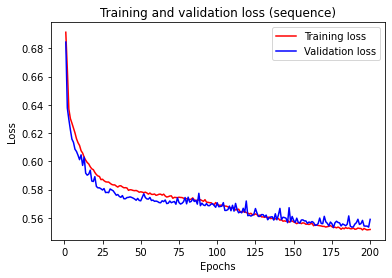

In [63]:
# plot training and validation loss
import matplotlib.pyplot as plt

train_loss = history_dict['main_output_loss']
val_loss = history_dict['val_main_output_loss']

acc = history_dict['main_output_accuracy']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, train_loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss (sequence)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('final_figures/M1_seq_train_val_loss_134b_200ep', dpi=400)
plt.show()

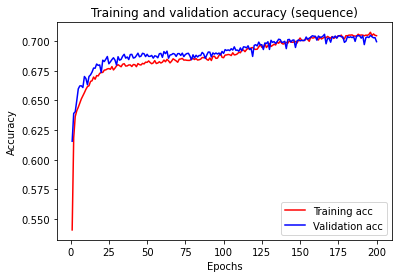

In [64]:
# plot training and validation accuracy
plt.clf()
train_acc = history_dict['main_output_accuracy']
val_acc = history_dict['val_main_output_accuracy']

acc = history_dict['main_output_accuracy']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, train_acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy (sequence)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('final_figures/M1_seq_train_val_acc_134b_200ep', dpi=400)
plt.show()

## Model evaluation

In [65]:
# train set
train_results = model.evaluate([np.asarray(X_train_peptide), np.asarray([1]*X_train_peptide.shape[0])], 
                               [np.asarray(y_train), np.asarray(y_train)])

print("%s: %.2f%%" % (model.metrics_names[1], train_results[1]*100))
print("%s: %.2f%%" % (model.metrics_names[3], train_results[3]*100))

1242/1242 [==============================] - ETA: 0s - loss: 0.6624 - main_output_loss: 0.5518 - aux_output_loss: 0.5529 - main_output_accuracy: 0.7053 - aux_output_accuracy: 0.706 - 3s 3ms/step - loss: 0.6619 - main_output_loss: 0.5514 - aux_output_loss: 0.5525 - main_output_accuracy: 0.7057 - aux_output_accuracy: 0.7066
main_output_loss: 55.14%
main_output_accuracy: 70.57%


In [66]:
# validation set
val_results = model.evaluate([np.asarray(X_val_peptide), np.asarray([1]*X_val_peptide.shape[0])], 
                             [np.asarray(y_val), np.asarray(y_val)])

print("%s: %.2f%%" % (model.metrics_names[1], val_results[1]*100))
print("%s: %.2f%%" % (model.metrics_names[3], val_results[3]*100))

414/414 [==============================] - 1s 3ms/step - loss: 0.6710 - main_output_loss: 0.5589 - aux_output_loss: 0.5602 - main_output_accuracy: 0.6996 - aux_output_accuracy: 0.6997
main_output_loss: 55.89%
main_output_accuracy: 69.96%


In [67]:
# test set
test_results = model.evaluate([np.asarray(X_test_peptide), np.asarray([1]*X_test_peptide.shape[0])], 
                              [np.asarray(y_test), np.asarray(y_test)])

print("%s: %.2f%%" % (model.metrics_names[1], test_results[1]*100))
print("%s: %.2f%%" % (model.metrics_names[3], test_results[3]*100))

710/710 [==============================] - 2s 3ms/step - loss: 0.6758 - main_output_loss: 0.5631 - aux_output_loss: 0.5636 - main_output_accuracy: 0.6958 - aux_output_accuracy: 0.6970A: 0s - loss: 0.6762 - main_output_loss: 0.5634 - aux_output_loss: 0.5642 - main_output_accuracy: 0.6957 - aux_output_accur
main_output_loss: 56.31%
main_output_accuracy: 69.58%


## Model prediction

In [68]:
df = pd.DataFrame({'Peptide': X_test['Peptide'], 'Detectability': y_test})
df.shape

(22704, 2)

In [69]:
test_predictions = model.predict([np.array([convertPeptide(pep, maxLength) for pep in df['Peptide']]), np.asarray([1]*X_test_peptide.shape[0])], 
                                 verbose=1)

710/710 [==============================] - 2s 2ms/step


In [70]:
df["Predictions"] = test_predictions[0].flatten()
df.head()

,Peptide,Detectability,Predictions
0,GYSLASLLAK,1,0.772385
1,LTSSNEINK,0,0.450480
2,ACTIAIR,0,0.363180
3,VGPVPVLVMSLLFIASVFMLHIWGK,0,0.006660
4,TLEEDVDDR,0,0.288882


In [71]:
df.to_csv('final_data/M1_seq_pred_134b_200epoch.tsv', sep='\t', index=False)

In [72]:
# visualise prediction distribution
import seaborn as sns

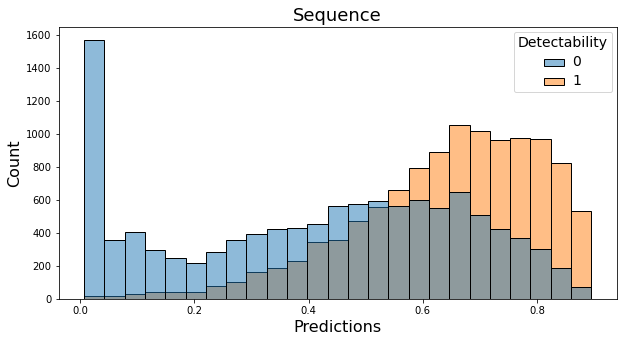

In [74]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.histplot(data=df, x=df['Predictions'], hue=df['Detectability'], stat='count', bins=25)
ax.set_title('Sequence', fontsize=18)
ax.set_xlabel('Predictions', fontsize=16)
ax.set_ylabel('Count', fontsize=16)
plt.setp(ax.get_legend().get_texts(), fontsize=14)
plt.setp(ax.get_legend().get_title(), fontsize=14)
plt.savefig('final_figures/M1_seq_hist_134b_200ep.png', dpi=400)

In [75]:
# confusion matrix
confusion_matrix = sklearn.metrics.confusion_matrix(y_test, np.rint(df['Predictions']))
confusion_matrix

array([[6499, 4853],
       [2053, 9299]], dtype=int64)

In [76]:
# Accuracy
from sklearn.metrics import accuracy_score
accuracy_score(y_test, np.rint(df['Predictions']))

0.6958245243128964

In [77]:
# Recall
from sklearn.metrics import recall_score
recall_score(y_test, round(df['Predictions']), average='binary')

0.8191508104298802

In [78]:
# Precision
from sklearn.metrics import precision_score
precision_score(y_test, np.rint(df['Predictions']), average='binary')

0.65708027133974

In [79]:
# F1 score
from sklearn.metrics import f1_score
f1_score(y_test, np.rint(df['Predictions']), average='binary')

0.7292189460476789

In [80]:
# MCC (Matthew's correlation coefficient)
from sklearn.metrics import matthews_corrcoef
matthews_corrcoef(y_test, np.rint(df['Predictions']))

0.4041352217390442

## Plot ROC curve

In [109]:
from sklearn.metrics import roc_curve, auc, roc_auc_score

In [113]:
fpr, tpr, thresholds = roc_curve(y_test, df['Predictions'])
auc_keras = auc(fpr, tpr)
auc_keras

0.7671200735910161

In [ ]:
def plot_roc_curve(y_test, predictions):
    fpr, tpr, thresholds = roc_curve(y_test, predictions)
    auc_keras = auc(fpr, tpr)
    
    plt.figure(1)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr_keras, tpr_keras, label='Keras (AUC = {:.3f})'.format(auc_keras))
    plt.xlabel('False positive rate')

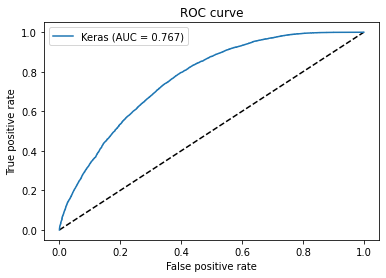

In [103]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (AUC = {:.3f})'.format(auc_keras))
#plt.plot(fpr_rf, tpr_rf, label='RF (area = {:.3f})'.format(auc_rf))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

# How peptide length affects prediction accuracy

In [61]:
len(df.loc[(df["Peptide"].str.len()==11)])

1757

In [113]:
df_30 = df.loc[(df["Peptide"].str.len()<=30)].reset_index(drop=True)
df_20 = df.loc[(df["Peptide"].str.len()<=20)].reset_index(drop=True)
df_10 = df.loc[(df["Peptide"].str.len()<=10)].reset_index(drop=True)